# Theano version of positive/negative samples

In [1]:
import numpy as np
from collections import OrderedDict
import os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu0,floatX=float32"

import theano.tensor as T
import theano
import sys
sys.path.append('../')
import negsamp
import matplotlib.pylab as plt
from progressbar import ProgressBar as progressbar 
%matplotlib inline

Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 4007)


## Parameter specification

In [20]:
# Params
m = 45               # number of negative samples
f = 4096
hidden1 = 200
hidden2 = 200
d = 200              # word vector size
V = 291
wdecay = 0.01        # weight decay

numlayers = 3
lr = 100
epochs = 10000
batchsize=256
weightfile = None # 'params-2x_0609.npz'
saveparams = 'params-2x_0704.npz'
pretrain = False

In [21]:
ls data/*

data/iaprtc_alexfc7.npz*     data/iaprtc_testlist.txt*
data/iaprtc_dictionary.txt*  data/iaprtc_trainlist.txt*

data/wiki-glove:
glove.6B.100d.txt  glove.6B.300d.txt  glove.6B.zip
glove.6B.200d.txt  glove.6B.50d.txt


## Data ingestion. Currently just read in numpy files.

In [22]:
data = np.load('data/iaprtc_alexfc7.npz')
D = open('data/iaprtc_dictionary.txt').read().splitlines()
train_ims = [ im.split('/')[-1] for im in open('data/iaprtc_trainlist.txt').read().splitlines() ]
test_ims = [ im.split('/')[-1] for im in open('data/iaprtc_testlist.txt').read().splitlines() ]
xTr = data['xTr'].T
yTr = data['yTr'].T
xTe = data['xTe'].T
yTe = data['yTe'].T
wc = yTr.sum(axis=0)+0.01-0.01

## Load in parameters/weights

In [23]:
if weightfile and pretrain:
    Wi = theano.shared(np.load(weightfile)['Wi'])
    if numlayers >= 2:
        Wh2 = theano.shared(np.random.ranf((hidden1, f)))
    elif numlayers >= 3:
        Wh3 = theano.shared(np.random.ranf((hidden2, hidden1)))
    Wc = theano.shared(np.load(weightfile)['Wc'])
elif weightfile:
    Wi = theano.shared(np.load(weightfile)['Wi'])
    if numlayers >= 2:
        Wh2 = theano.shared(np.load(weightfile)['Wh2'])
    if numlayers >= 3:
        Wh3 = theano.shared(np.load(weightfile)['Wh3'])
    Wc = theano.shared(np.load(weightfile)['Wc'])
    progloss = np.load(weightfile)['Losses']
else:
    # Need to change these to normal distributed
    if numlayers == 2:
        Wh2 = theano.shared(0.01*(np.random.ranf((hidden1, f))-0.5) )
        Wi = theano.shared(0.01*(np.random.ranf((d, hidden1))-0.5) )
    if numlayers == 3:
        Wh2 = theano.shared(0.01*(np.random.ranf((hidden1, f))-0.5) )
        Wh3 = theano.shared(0.01*(np.random.ranf((hidden2, hidden1))-0.5) )
        Wi = theano.shared(0.01*(np.random.ranf((d, hidden2))-0.5) )
        print "Initialized higher-order layers to {}, {}".format(Wh2.get_value().shape, Wh3.get_value().shape)
    Wc = theano.shared(0.01*(np.random.ranf((V, d))-0.5) )
    progloss= np.array([])
    print "Initialized Wi, and Wc shapes: {},{},{}".format(Wh2.get_value().shape,Wi.get_value().shape,Wc.get_value().shape)

Initialized higher-order layers to (200, 4096), (200, 200)
Initialized Wi, and Wc shapes: (200, 4096),(200, 200),(291, 200)


## Helper and utility functions

In [24]:
def showdata( Wcn, minblk=True, thetitle=None, colorbar=False, blackwhite=False ):
    if minblk:
        Wcmind1 = np.array(Wcn.shape).min()
        Wcmind2 = np.array(Wcn.shape).min()
    else:
        Wcmind1 = Wcn.shape[0]
        Wcmind2 = Wcn.shape[1]
    plt.figure
    if blackwhite:
        print '%d, %d'%(Wcmind1,Wcmind2)
        plt.imshow(Wcn[:Wcmind1,:Wcmind2], cmap='Greys_r', interpolation='nearest')
    else:
        plt.imshow(Wcn[:Wcmind1,:Wcmind2]);
    if thetitle:
        plt.title(thetitle)
    if colorbar:
        plt.colorbar()
    plt.show()

    
# Define the sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Define rectified linear unit (relu)
def relu(x):
    return np.maximum(x, 0)

## Mathy Part

### Cost Function:
1. One Layer: $$ y_p = \sigma(W_c W_i x^T) $$
2. Two Layers: $$ y_p = \sigma( W_c W_i \sigma( W_h x^T )) $$

We are doing SGD only (no momentum)

In [25]:
# Negative sampler
ns = negsamp.NegativeSampler(wc / wc.sum())

# Define functionality
x = T.matrix()
p = T.matrix()
n = T.matrix()

# Cross correlation
if numlayers==1:
    xcorr = Wc.dot(Wi.dot(x.T)).T
elif numlayers==2:
    # xcorr = Wc.dot(Wi.dot(T.nnet.sigmoid(Wh2.dot(x.T)))).T
    xcorr = Wc.dot(Wi.dot(T.nnet.relu(Wh2.dot(x.T)))).T
elif numlayers==3:
    xcorr = Wc.dot(Wi.dot(T.nnet.relu(Wh3.dot(T.nnet.relu(Wh2.dot(x.T)))))).T

# LOSS FUNCTION
# Because p and n are {-1,0,1}, these two are the same
# loss = -(T.log(T.nnet.sigmoid(p*xcorr)) + T.log(T.nnet.sigmoid(-n*xcorr))).mean()
# loss = -T.log(T.nnet.sigmoid( (p-n).dot(xcorr)  )).mean()
# loss = (-p * T.log(T.nnet.sigmoid(xcorr)) + n * T.log(T.nnet.sigmoid(xcorr))).mean()
loss = -(p*T.log(T.nnet.sigmoid(xcorr)) + n*T.log(T.nnet.sigmoid(-xcorr))).mean()
# 
# Cross-entropy
# loss = (n-p)*( T.log( T.nnet.sigmoid(xcorr) ) ).mean()
#
# Binary cross-entropy
# loss = -(p*(T.log( T.nnet.sigmoid(xcorr))) + (1-p)*(T.log( 1-T.nnet.sigmoid(xcorr) ))).mean()

# Define the gradient updates. Use positive for maximization
if numlayers==1:
    params = [Wi, Wc]
    gWi, gWc = T.grad(loss, params)
    sgd = OrderedDict( { Wi: Wi - lr*gWi, Wc: Wc - lr*gWc } )
elif numlayers==2:
    params = [Wi, Wc, Wh2]
    gWi, gWc, gWh2 = T.grad(loss, params)
    sgd = OrderedDict( { Wi: Wi - lr*gWi, Wc: Wc - lr*gWc, Wh2: Wh2 - lr*gWh2 } )
elif numlayers==3:
    params = [Wi, Wc, Wh2, Wh3]
    gWi, gWc, gWh2, gWh3 = T.grad(loss, params)
    sgd = OrderedDict( { Wi: Wi - lr*gWi, Wc: Wc - lr*gWc, Wh2: Wh2 - lr*gWh2, Wh3: Wh3 - lr*gWh3 } )

# Compile to theano functionality
train = theano.function( [x,p,n], outputs=loss, updates=sgd, allow_input_downcast=True )
predict= theano.function( [x], outputs=xcorr, allow_input_downcast=True )

## Do SGD on the cost function above

In [ ]:
progbar = progressbar(len(yTr))

# Iterate through the data size
for j in xrange(epochs):
    print "Epoch "+str(j)
    k=0
    totloss = 0.0
    batloss = 0.0
    randorder = np.random.permutation(len(yTr))
    for i in range(0,len(randorder),batchsize):
        
        indata = xTr[i:i+batchsize]
        outdata= yTr[i:i+batchsize]

        nsv = ns.negsampv(outdata, m)
        lossval = train( indata, outdata, nsv )
        totloss += lossval
        batloss += lossval

        k+=1
        if k % 16 == 0:
            # Progress and loss
            progbar.animate(k*batchsize)
            print('\nlosses (inst, bat, tot)=({},{},{})'.format(lossval, batloss, totloss))
            
    print ""
    print "Total loss on epoch "+str(j)+" = "+str(totloss)+"\n"
    progloss = np.append(progloss, totloss)
    print "Progress: {}".format( progloss )
    plt.plot(progloss)

    
    if numlayers==1:
        np.savez(saveparams, Wi=Wi.get_value(), Wc=Wc.get_value(), Epoch=j, Losses=progloss)      
    elif numlayers==2:
        np.savez(saveparams, Wi=Wi.get_value(), Wh2=Wh2.get_value(), Wc=Wc.get_value(), Epoch=j, Losses=progloss)      
    elif numlayers==3:
        np.savez(saveparams, Wi=Wi.get_value(), Wh2=Wh2.get_value(), Wh3=Wh3.get_value(), Wc=Wc.get_value(), Epoch=j, Losses=progloss)      


[*****************93%***************   ]  16385 of 17665 complete 
losses (inst, bat, tot)=(0.0962084118206,1.54684331141,1.54684331141)


### Save the arrays to parameter files

In [ ]:
if numlayers==1:
    np.savez(saveparams, Wi=Wi.get_value(), Wc=Wc.get_value(), Epoch=j)      
elif numlayers==2:
    np.savez(saveparams, Wi=Wi.get_value(), Wh2=Wh2.get_value(), Wc=Wc.get_value(), Epoch=j, Losses=progloss)      
elif numlayers==3:
    np.savez(saveparams, Wi=Wi.get_value(), Wh2=Wh2.get_value(), Wh3=Wh3.get_value(), Wc=Wc.get_value(), Epoch=j, Losses=progloss)      

# Numpy verification and debugging

### Get arrays from GPU, and make sample inputs

[ 140.92060172    7.62086023    6.96315359 ...,    6.95386771    6.96357229
    6.95951553]


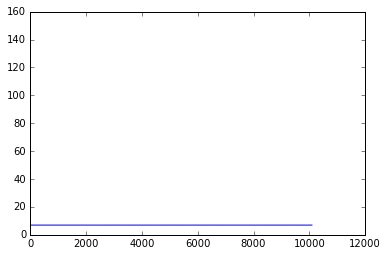

In [32]:
# Get parameters from the GPU arrays
Ws = []
if numlayers >= 3:
    Ws.append( Wh3.get_value() )
if numlayers >= 2:
    Ws.append( Wh2.get_value() )
Win  = Wi.get_value()
Wout = Wc.get_value()
# plt.stem(W0.dot(xTe[40]))

xD = xTe[:256]
yD = yTe[:256]
npp = yD
npn = ns.negsampv(yD, m)

plt.plot(progloss)
print progloss
